In [ ]:
from pykml import parser
import numpy as np
import pandas as pd
from ll_xy import lonlat_to_xy
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cdsapi
#https://cds.climate.copernicus.eu/requests?tab=all to view requests
import cartopy
import shapely
import xarray

In [28]:
with open('../../flade.kml', 'r') as f:
    root = parser.parse(f).getroot()
    
namespace = {"kml": 'http://www.opengis.net/kml/2.2'}
pms = root.xpath(".//kml:Placemark[.//kml:Polygon]", namespaces=namespace)


x = str(pms[0].Polygon.outerBoundaryIs.LinearRing.coordinates)

x = x.replace('\t','')
x = x.replace('\n','')
x = x.replace('0 ','')
x = x[:-1]
coords = x.split(',')
polylats = np.array([float(n) for n in coords[1::2]])
polylons = np.array([float(n) for n in coords[0::2]])

xpoly,ypoly = lonlat_to_xy(polylons,polylats,hemisphere='n')
dfpoly = pd.DataFrame({'x':xpoly,'y':ypoly,'lons':polylons,'lats':polylats})
dfpoly.to_csv('Flade_poly_coords.csv')
np.nanmin(polylats),np.nanmax(lats),np.nanmin(lons),np.nanmax(lons)

(80.97842398906218, 81.79504077375327, -18.50749931075323, -11.571139837805)

In [24]:
img_dir = '/home/robbie/Dropbox/ARCTEX/projects'
file = 'Flade_S1.tiff'
xds = xarray.open_dataset(f'{img_dir}/{file}',engine="rasterio")

basemap = np.array(xds.to_array())[0,0]

gt_lon = np.array(xds.x)
gt_lat = np.array(xds.y)
S1longrid = np.repeat(gt_lon[np.newaxis,:],len(gt_lat),axis=0)
S1latgrid = np.repeat(gt_lat[:,np.newaxis],len(gt_lon),axis=1)

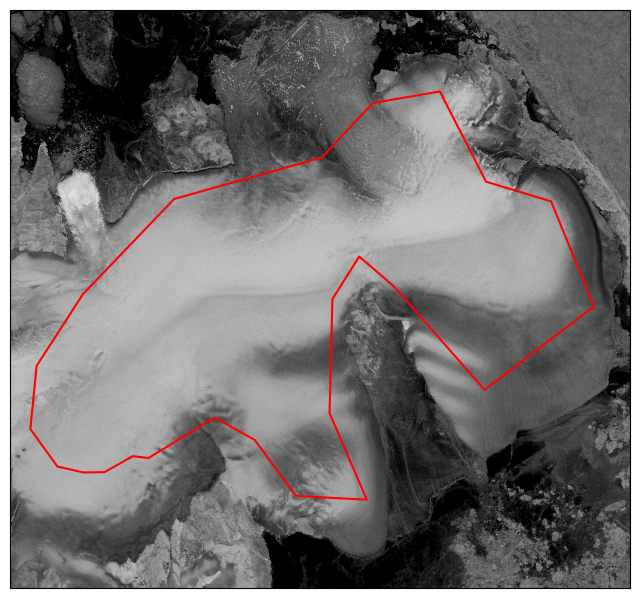

In [30]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.NorthPolarStereo())


ax.set_extent([np.nanmin(polylons),np.nanmax(polylons),np.nanmax(polylats),np.nanmin(polylats)], ccrs.PlateCarree())

ax.pcolormesh(S1longrid,S1latgrid,basemap,
             transform=ccrs.PlateCarree(),zorder=2,cmap='grey')

ax.plot(polylons,
         polylats,transform=ccrs.PlateCarree(),zorder=3,color='r')

plt.show()

In [17]:
dataset = "reanalysis-era5-single-levels"

days = [str(x).zfill(2) for x in np.arange(1,32)]
months = [str(x).zfill(2) for x in np.arange(1,13)]
hours = [str(x).zfill(2)+':00' for x in np.arange(0,24)]

for year in np.arange(2003,2024):
    
    request = {
        "product_type": ["reanalysis"],
        "variable": ["10m_u_component_of_wind",
        "10m_v_component_of_wind",
        "2m_temperature",
        "total_precipitation",
        "surface_net_thermal_radiation",
        "surface_solar_radiation_downwards",
        "total_cloud_cover",
        "precipitation_type",
        "snowfall"],
        "year": [str(year)],
                    'area': [
                    82, -23, 80,
                    -10,
                ],
        "month": months,
        "day": days,
        "time": hours,
        "data_format": "netcdf",
        "download_format": "unarchived"
    }
    
    client = cdsapi.Client()
    client.retrieve(dataset, request).download(f"flade_{year}.nc")

    break

2025-01-14 09:53:08,395 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2025-01-14 09:53:08,397 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-01-14 09:53:08,399 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2025-01-14 09:53:08,402 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using t

KeyboardInterrupt: 

In [31]:
d = Dataset('flade.nc')

lons = np.array(d['longitude'])
lats = np.array(d['latitude'])

latgrid = np.repeat(lats[:,np.newaxis],lons.shape[0],axis=1)
longrid = np.repeat(lons[np.newaxis,:],lats.shape[0],axis=0)

longrid.shape,latgrid.shape



((9, 53), (9, 53))

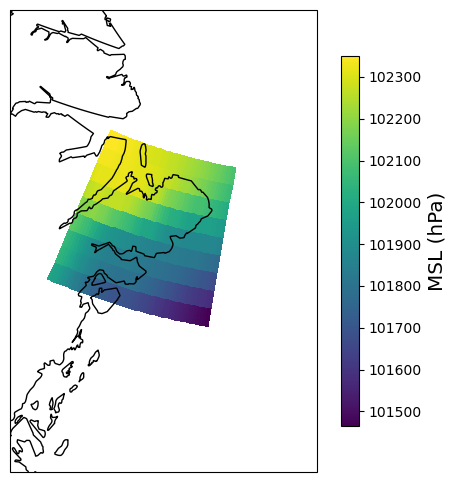

In [32]:
msl = np.array(d['msl'])[0]

# msl[latgrid<80]=np.nan
# msl[latgrid>82]=np.nan

fig = plt.figure(figsize=(6,6))
proj = ccrs.NorthPolarStereo()
ax = plt.axes(projection=proj)


ax.set_extent([-22, -2,84, 78], ccrs.PlateCarree())

ax.add_feature(cartopy.feature.COASTLINE,zorder=5)

cont = ax.pcolormesh(longrid,
                      latgrid,
                  msl,
                     # vmin=0,vmax=1,
                  transform=ccrs.PlateCarree())

cb = fig.colorbar(cont,shrink=0.8)
cb.set_label('MSL (hPa)',fontsize='x-large')
# fig.savefig('Ice_Edge_Jan25.png',dpi=400,bbox_inches='tight')

# Calculate which grid cells fall within polygon

nan out ones which don't

In [33]:
x = np.array(d['msl'])[0]


polylons = np.array(dfpoly['lons'])
polylats = np.array(dfpoly['lats'])

poly_coords = [(x,y) for x,y in zip(dfpoly['x'],
                                    dfpoly['y'])]
polygon = shapely.Polygon(poly_coords)


xgrid,ygrid=lonlat_to_xy(longrid.flatten(),
                        latgrid.flatten(),
                        hemisphere='n')

pts = [shapely.geometry.Point(x,y) for x,y in zip(xgrid,ygrid)]

within = np.array([pt.within(polygon) for pt in pts])

mask = within.reshape(longrid.shape)

mask[mask<0]=np.nan

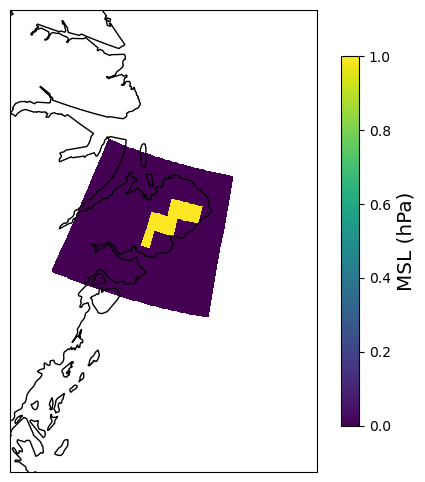

In [34]:
fig = plt.figure(figsize=(6,6))
proj = ccrs.NorthPolarStereo()
ax = plt.axes(projection=proj)


ax.set_extent([-22, -2,84, 78], ccrs.PlateCarree())

ax.add_feature(cartopy.feature.COASTLINE,zorder=5)

cont = ax.pcolormesh(longrid,
                      latgrid,
                  mask[:-1,:-1],
                     vmin=0,vmax=1,
                  transform=ccrs.PlateCarree())

cb = fig.colorbar(cont,shrink=0.8)
cb.set_label('MSL (hPa)',fontsize='x-large')
# fig.savefig('Ice_Edge_Jan25.png',dpi=400,bbox_inches='tight')